In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from collections import namedtuple, deque
import os
import random
import sys
import time

from itertools import count
from IPython.display import display, clear_output
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import torch.optim as optim

sys.path.append('home/brysongray/tractogrpahy/')
from agent.sac_tracker import Actor, Critic
from env.sac_tracking_env import Environment
from replay_memory import ReplayMemory
import tracking_interface

DEVICE = "cuda"

In [48]:
class Net(torch.nn.Module):
    ''' Takes in state and returns gaussian mean and logvar (in 2d).
    
    Takes in a 21x21 image, 
    typically this is 1 channel of an "image"
    1 channel is a canvas we are drawing on
    (sometimes) 2 channel are the x and y components of our action
    
    Output will be either 3 numbers (policy net), meanx, meany, logvar (isotropic)
    Or for a qnet, it will be 1 number (expected future reward)
    
    The network is 3 convs and batchnorms, followed by 2 linear layers
    '''
    def __init__(self,chin=4,ch0=16,chout=4):
        super().__init__()        
        k = 3
        p = (k-1)//2
        s = 2
        self.c0 = torch.nn.Conv3d(chin,ch0,k,s,p)
        self.b0 = torch.nn.BatchNorm3d(ch0)
        self.c1 = torch.nn.Conv3d(ch0,2*ch0,k,s,p)
        self.b1 = torch.nn.BatchNorm3d(2*ch0)
        self.c2 = torch.nn.Conv3d(2*ch0,4*ch0,k,s,p)
        self.b2 = torch.nn.BatchNorm3d(4*ch0)
        self.l0 = torch.nn.Linear(5**3*64,64)        
        self.l1 = torch.nn.Linear(64,chout)
    def forward(self,x):
        x = self.c0(x)
        x = self.b0(x)
        x = torch.relu(x)
        
        x = self.c1(x)
        x = self.b1(x)
        x = torch.relu(x)
        
        x = self.c2(x)
        x = self.b2(x)
        x = torch.relu(x)
        
        
        x = self.l0(x.reshape(x.shape[0],-1))
        x = torch.relu(x)
        
        x = self.l1(x)
        return x


def sample_from_output(out, random=False):    
    '''
    A function to differentiably sample
    '''
    
    mean = out[:,:3] # component 0, 1 and 2
    logvar = out[:,3:] # logvar component 3
    # I want the mean and logvar to be squashed
    # note it would probably be better to not squash components independently
    # better to squash them by their vector norm
    # but it's not a big deal
    meannorm = torch.linalg.norm(mean, dim=-1, keepdim=True)
    meannorm_ = torch.tanh(meannorm)*10 # maximum of 10
    mean = mean * meannorm_/(meannorm + torch.finfo(torch.float).eps)
    logvar = torch.tanh(logvar)*3 + 1 # no very low variance (std is order of 1 pixel) 
    # between 0 and 4
    # std between 1 and 7.4
    # sample = (torch.randn(out.shape[0],3).to(device=out.device)*torch.exp(logvar*0.5) + mean)
    # sample = sample * torch.tensor([[0,1,1]], device=out.device)
    direction_dist = torch.distributions.MultivariateNormal(mean[:,:2], torch.exp(logvar)[:,None]*torch.eye(2, device=DEVICE)[None])

    return direction_dist


def show_state(env, returns, rewards, policy_loss, fig):
    ax = fig.axes
    clear_output(wait=True)
    for x in ax:
        x.cla()

    img = env.img.data[:3].clone().detach().cpu()
    path = env.img.data[3].clone().detach().cpu()
    mask = env.mask[0].detach().clone().cpu()
    true_density = env.true_density.data[0].detach().clone().cpu()
    for j in range(3):
        ax[j].imshow(img.permute(1,2,3,0).amax(j))
        ax[j].imshow(path.amax(j), cmap='plasma', alpha=0.5)

    for j in range(3):
        toshow = torch.stack((true_density.amax(j), path.amax(j), mask.amax(j)), dim=-1)
        ax[j+3].imshow(toshow)
        # ax[j+3].imshow(true_density.amax(j), cmap='Reds')
        # ax[j+3].imshow(path.amax(j), cmap='Greens', alpha=0.5)
        # ax[j+3].imshow(mask.amax(j), cmap='Blues', alpha=0.5)


    ax[6].plot(rewards)
    ax[6].set_title("ep rewards")

    ax[7].plot(returns)
    ax[7].set_title("ep returns")
    
    ax[8].plot(policy_loss)
    ax[8].set_title("policy loss")

    display(fig)
    # clear_output(wait = True)
    # plt.pause(0.1)
    
    return


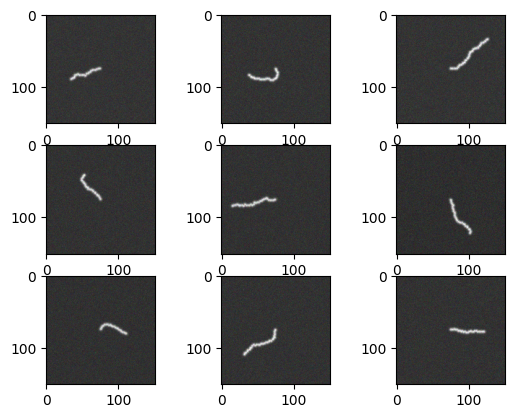

In [47]:
f = "/home/brysongray/tractography/neuron_trx/training_data/bendy_thin/"
fig, ax = plt.subplots(3,3)
ax = ax.ravel()
for i,img_file in enumerate(os.listdir(f)[18:27]):
    img, true_density, mask = list(torch.load(os.path.join(f,img_file), weights_only=True).values())
    ax[i].imshow(img.permute(1,2,3,0).amax(0))

In [49]:
f = open('/home/brysongray/tractography/neuron_trx/configs/sac_config_8-9-24.json')
args = json.load(f)

img_dir = args["img_dir"]
seeds = args["seeds"]
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 128
gamma = args["gamma"] if "gamma" in args else 0.99
tau = args["tau"] if "tau" in args else 0.005
lr = args["lr"] if "lr" in args else 0.001
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17

In [50]:
# instantiate environment
env = Environment(img_dir,
                  radius=patch_radius,
                  seeds=seeds,
                  step_size=step_size,
                  step_width=step_width,
                  max_len=150,
                  alpha=alpha,
                  beta=beta,
                  friction=friction,
                  branching=False)

In [51]:
in_channels = 4
input_size = 2*patch_radius+1
init_temperature = 0.001
# n_filters = 16
# start_steps = 1

# actor = Actor(in_channels, input_size, n_filters).to(DEVICE)
# Q = Critic(in_channels, input_size, n_filters).to(DEVICE)
# Q_target = Critic(in_channels, input_size, n_filters).to(DEVICE)

# Q_target.load_state_dict(Q.state_dict())

dtype = torch.float32

actor = Net(chin=in_channels, chout=4)
actor = actor.to(device=DEVICE,dtype=dtype)

Q1 = Net(chin=in_channels+3,chout=1)
Q1 = Q1.to(device=DEVICE,dtype=dtype)
Q2 = Net(chin=in_channels+3,chout=1)
Q2 = Q2.to(device=DEVICE,dtype=dtype)
Q1_target = Net(chin=7,chout=1)
Q1_target = Q1_target.to(device=DEVICE,dtype=dtype)
Q2_target = Net(chin=7,chout=1)
Q2_target = Q2_target.to(device=DEVICE,dtype=dtype)
Q1_target.load_state_dict(Q1.state_dict())
Q2_target.load_state_dict(Q2.state_dict())

log_alpha = torch.tensor(np.log(init_temperature)).to(DEVICE)
log_alpha.requires_grad = True
target_entropy = 2.0

Q1_optimizer = optim.AdamW(Q1.parameters(), lr=lr)
Q2_optimizer = optim.AdamW(Q2.parameters(), lr=lr)
actor_optimizer = optim.AdamW(actor.parameters(), lr=lr)
log_alpha_optimizer = torch.optim.Adam([log_alpha], lr=lr)

criterion = torch.nn.MSELoss()
memory = ReplayMemory(10000, obs_shape=(in_channels,input_size,input_size,input_size), action_shape=(3,))
# memory = ReplayMemory(10000)

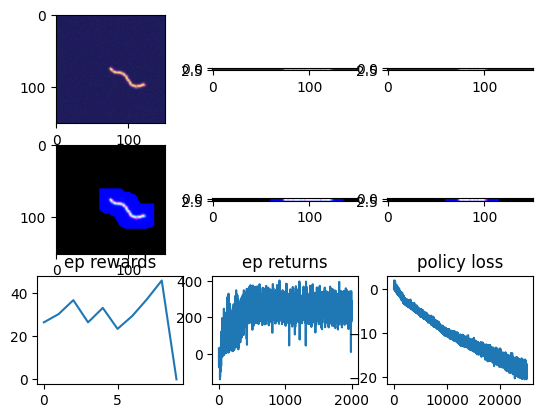

100%|██████████| 2000/2000 [55:01<00:00,  1.65s/it]


<Figure size 640x480 with 0 Axes>

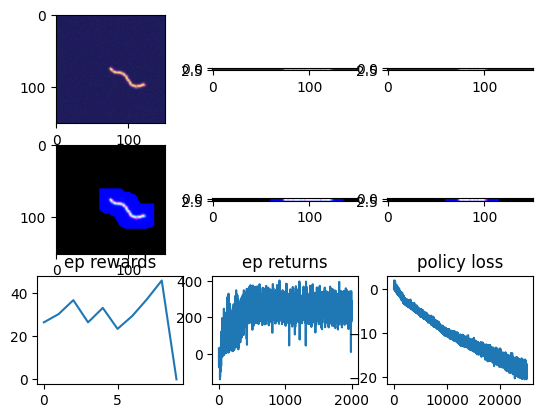

In [53]:
# train
episodes = 2000
update_after = 128

steps_done = 0
updates_per_step = 1
num_updates = 0
policy_loss = []
ep_returns = []

# Train the Network
fig1, ax = plt.subplots(3,3, figure=plt.figure(num=1))

plt.ion()
for i in tqdm(range(episodes)):
    obs = env.get_state()
    ep_return = 0
    ep_rewards = []
    for t in count():
        actor.eval()
        with torch.no_grad():
            if steps_done < update_after:
                action = torch.randn(3).to(DEVICE)*3
                action = action * torch.tensor([0,1,1], device=DEVICE)
            else:
                actor_out = actor(obs)
                direction_dist = sample_from_output(actor_out)
                action = direction_dist.rsample()
                action = torch.concatenate((torch.tensor([0.0], device=DEVICE), action[0]))
            
            steps_done += 1
            # take step, get observation and reward, and move index to next streamline
            next_obs, reward, terminated = env.step(action)
            ep_return += reward.cpu().item()
            ep_rewards.append(reward.cpu().item())

            # Store the transition in memory
            memory.push(obs.cpu(), action.cpu(), next_obs.cpu(), reward.cpu(), terminated)
        
        if steps_done >= update_after:
            updates_per_step = 1
            # Perform updates once there is sufficient transitions saved.
            actor.train()
            for i in range(updates_per_step):
                num_updates += 1
                obs, actions, next_obs, rewards, dones = memory.sample(batch_size, replacement=False)

                # Perform one step of the optimization on the Q networks.
                # compute targets
                with torch.no_grad():
                    # sample next actions from the current policy
                    actor_out = actor(next_obs) # set steps_done to start_steps so that this samples from the current policy
                    direction_dist = sample_from_output(actor_out)
                    next_directions = direction_dist.rsample()
                    logprobs = direction_dist.log_prob(next_directions)
                    next_directions = torch.concatenate((torch.zeros(next_directions.shape[0],1, device=DEVICE), next_directions), dim=1)
                    # get target q-values
                    next_states = torch.concatenate((next_obs, torch.ones((next_obs.shape[0], 1, next_obs.shape[2], next_obs.shape[3], next_obs.shape[4]), 
                                                        device=DEVICE)*next_directions[:,:,None,None,None]), dim=1)
                    Q1_target_vals = Q1_target(next_states) # vector of q-values for each choice
                    Q2_target_vals = Q2_target(next_states)
                    targets = rewards + gamma * torch.logical_not(dones) * (torch.minimum(Q1_target_vals, Q2_target_vals) - log_alpha.exp() * logprobs[:,None])
                # compute q-values to compare against targets
                current_state = torch.concatenate((obs, 
                                    torch.ones((obs.shape[0], 1, obs.shape[2], obs.shape[3], obs.shape[4]), 
                                                device=DEVICE)*actions[:,:,None,None,None]), dim=1)
                Q1_vals = Q1(current_state)
                Q1_loss = criterion(Q1_vals, targets)
                Q1_optimizer.zero_grad()
                Q1_loss.backward()
                Q1_optimizer.step()

                Q2_vals = Q2(current_state)
                Q2_loss = criterion(Q2_vals, targets)
                Q2_optimizer.zero_grad()
                Q2_loss.backward()
                Q2_optimizer.step()

                for Q,Q_target in zip([Q1, Q2], [Q1_target, Q2_target]):
                    Q_state_dict = Q.state_dict()
                    Q_target_state_dict = Q_target.state_dict()
                    for key in Q_state_dict:
                        Q_target_state_dict[key] = Q_state_dict[key]*tau + Q_target_state_dict[key]*(1-tau)
                    Q_target.load_state_dict(Q_target_state_dict)

                # Perform one step of optimization on the policy network
                # sample actions from policy
                actor_out = actor(obs)
                direction_dist = sample_from_output(actor_out, random=False)
                directions = direction_dist.rsample()
                logprobs = direction_dist.log_prob(directions)
                directions = torch.concatenate((torch.zeros(directions.shape[0],1, device=DEVICE), directions), dim=1)

                # get expected Q-vals
                current_state = torch.concatenate((obs, 
                                    torch.ones((obs.shape[0], 1, obs.shape[2], obs.shape[3], obs.shape[4]), 
                                                device=DEVICE)*directions[:,:,None,None,None]), dim=1)
                Q1_vals = Q1(current_state)[:,0]
                Q2_vals = Q2(current_state)[:,0]
                # entropy regularized Q values
                loss = -torch.mean(torch.minimum(Q1_vals, Q2_vals) - log_alpha.exp().detach() * logprobs[:,None]) # The loss function is multiplied by -1 to do gradient ascent instead of decent.
                policy_loss.append(loss.item())
                actor_optimizer.zero_grad()
                loss.backward()
                actor_optimizer.step()

                log_alpha_optimizer.zero_grad()
                alpha_loss = (log_alpha.exp() * (-logprobs - target_entropy).detach()).mean()
                alpha_loss.backward()
                log_alpha_optimizer.step()
                
        if terminated:
            ep_returns.append(ep_return)
            show_state(env, ep_returns, ep_rewards, policy_loss, fig1)
            env.reset()
            break

        # if not terminated, move to the next state
        obs = env.get_state() # the head of the next streamline
        


In [15]:
np.mean(ep_returns)

np.float64(-3.1333923625946043)